# 04 - Sector-Level Performance Decomposition (Fuel-Neutral)

## Objective
Analyze sector-level performance and degradation patterns
using fuel-corrected lap framework.

In [38]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from src.config import RACE_YEAR, RACE_NAME

In [40]:
laps = pd.read_csv(
    f"../data/processed/{RACE_YEAR}_{RACE_NAME}_fuel_corrected.csv"
)

laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Sector1Sec,Sector2Sec,Sector3Sec,FuelProxy,StintLap,Warmup,SafetyCar,StintLap_c,FuelProxy_c,FullyCorrectedLap
0,0 days 01:05:53.876000,VER,1,0 days 00:01:37.974000,2.0,1.0,NaN,NaN,0 days 00:00:31.342000,0 days 00:00:42.504000,...,31.342,42.504,24.128,55.0,0,1,0,-7.241794,26.449672,96.192236
1,0 days 01:07:31.882000,VER,1,0 days 00:01:38.006000,3.0,1.0,NaN,NaN,0 days 00:00:31.388000,0 days 00:00:42.469000,...,31.388,42.469,24.149,54.0,1,1,0,-6.241794,25.449672,96.299644
2,0 days 01:09:09.858000,VER,1,0 days 00:01:37.976000,4.0,1.0,NaN,NaN,0 days 00:00:31.271000,0 days 00:00:42.642000,...,31.271,42.642,24.063,53.0,2,1,0,-5.241794,24.449672,96.345051
3,0 days 01:10:47.893000,VER,1,0 days 00:01:38.035000,5.0,1.0,NaN,NaN,0 days 00:00:31.244000,0 days 00:00:42.724000,...,31.244,42.724,24.067,52.0,3,0,0,-4.241794,23.449672,96.266720
4,0 days 01:12:25.879000,VER,1,0 days 00:01:37.986000,6.0,1.0,NaN,NaN,0 days 00:00:31.341000,0 days 00:00:42.632000,...,31.341,42.632,24.013,51.0,4,0,0,-3.241794,22.449672,96.293128


In [42]:
laps = laps[laps["SafetyCar"] == 0].copy()

In [44]:
laps["StintLap_c"] = laps["StintLap"] - laps["StintLap"].mean()
laps["FuelProxy_c"] = laps["FuelProxy"] - laps["FuelProxy"].mean()

In [46]:
sector_results = []

for sector in ["Sector1Sec", "Sector2Sec", "Sector3Sec"]:
    
    X = laps[[
        "StintLap_c",
        "FuelProxy_c",
        "Warmup"
    ]]
    
    y = laps[sector]
    
    model = LinearRegression()
    model.fit(X, y)
    
    sector_results.append({
        "Sector": sector,
        "DegradationSlope": model.coef_[0],
        "FuelSensitivity": model.coef_[1],
        "WarmupPenalty": model.coef_[2]
    })

pd.DataFrame(sector_results)

,Sector,DegradationSlope,FuelSensitivity,WarmupPenalty
0,Sector1Sec,0.031524,0.017230,-0.016688
1,Sector2Sec,0.042172,0.037151,-0.152860
2,Sector3Sec,0.027785,0.021027,-0.043191


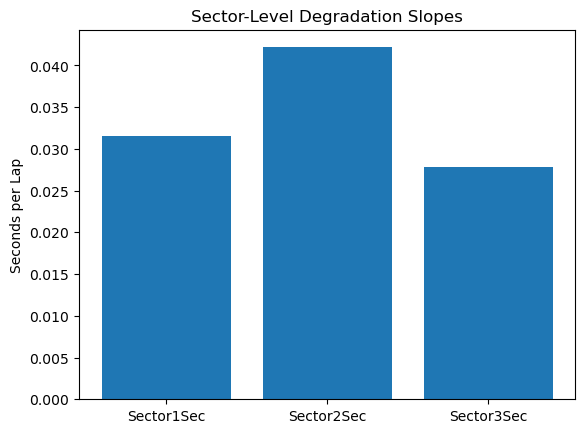

In [48]:
sector_df = pd.DataFrame(sector_results)

plt.bar(sector_df["Sector"], sector_df["DegradationSlope"])
plt.title("Sector-Level Degradation Slopes")
plt.ylabel("Seconds per Lap")
plt.show()

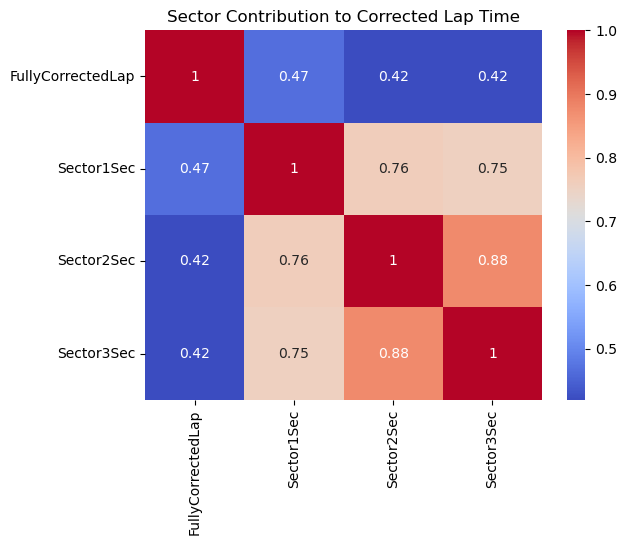

In [50]:
corr = laps[
    ["FullyCorrectedLap", "Sector1Sec", "Sector2Sec", "Sector3Sec"]
].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Sector Contribution to Corrected Lap Time")
plt.show()

## Sector 1

### DegradationSlope: 0.0315 sec/lap

- Moderate tyre degradation sensitivity.
- Suggests tyre wear impacts this sector, but not heavily.
- Likely high-speed or aero-dominant section.

### FuelSensitivity: 0.0172

- Low fuel sensitivity.
- Indicates mass does not significantly affect performance here.
- Likely more downforce-limited than traction-limited.

### WarmupPenalty: -0.0167

- Slight negative penalty (unexpected).
- Possibly drivers pushing harder after warm-up.

## Sector 2 (Most Interesting)

### DegradationSlope: 0.0422 sec/lap (Highest)

- This sector degrades fastest.
- Likely technical / corner-heavy / traction-limited.
- Rear tyre wear likely dominant.

### FuelSensitivity: 0.0372 (Highest)

- Strong fuel sensitivity.
- Mass significantly impacts performance here.
- Suggests acceleration-heavy or elevation-change sector.

### WarmupPenalty: -0.1529 (Large magnitude)

- This is significant.
- Early stint laps in this sector are substantially slower.
- Suggests high tyre temperature dependency.
- Could indicate:
    - Heavy braking zone
    - Traction exit sensitivity
    - Front grip build-up phase

### Sector 2 appears to be:

The most performance-sensitive sector of the circuit.

## Sector 3

### DegradationSlope: 0.0278

- Lower degradation than Sector 2.
- Still tyre-sensitive but less severe.

### FuelSensitivity: 0.0210

- Moderate mass effect.
- Likely mixed corner + straight section.

### WarmupPenalty: -0.0432

- Noticeable warm-up effect.
- Less extreme than Sector 2.

## Sector-Level Interpretation

Sector 2 exhibits the highest degradation slope and fuel sensitivity, indicating it is the most performance-critical portion of the circuit. The strong warm-up penalty suggests significant tyre temperature dependence, likely due to heavy braking or traction-dominated corners.

Sector 1 shows moderate degradation with lower fuel sensitivity, suggesting a more aero-dominant section.

Sector 3 demonstrates intermediate behavior, with noticeable but lower degradation and warm-up effects.

Overall, Sector 2 is the primary contributor to lap time sensitivity under both fuel load and tyre degradation conditions.